In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score
import joblib


In [ ]:
# ⚠️ Change this to your actual file path
file_path = '/content/drive/MyDrive/pakistan_tomato_disease_forecast4000.csv'

df = pd.read_csv(file_path)
print("✅ Dataset loaded successfully!")
print("Shape:", df.shape)
df.head()


✅ Dataset loaded successfully!
Shape: (14610, 19)


,date,tmax,tmin,rain,rhmax,rhmin,solar,wind,city,tmean,rhmean,LeafWetness_est,LateBlight_Risk,EarlyBlight_Risk,BacterialSpot_Risk,MosaicVirus_Risk,YellowVirus_Risk,LeafMold_Risk,Septoria_Risk
0,2021-01-01,16.2,5.0,0.0,96,52,12.08,9.5,Lahore,10.60,74.0,0,Low,Low,Low,Low,Low,Low,Low
1,2021-01-02,16.1,3.7,2.6,100,59,9.51,11.7,Lahore,9.90,79.5,1,Low,Low,Low,Low,Low,Low,Low
2,2021-01-03,18.0,10.2,2.4,95,69,7.90,15.3,Lahore,14.10,82.0,1,Low,Low,Low,Low,Low,Low,Low
3,2021-01-04,19.6,12.4,11.2,97,68,7.87,15.5,Lahore,16.00,82.5,1,Medium,Low,Low,Low,Low,Low,Low
4,2021-01-05,16.3,13.8,23.1,95,90,3.34,20.5,Lahore,15.05,92.5,1,High,Low,Low,Low,Low,Low,Low


In [ ]:
# Drop non-numeric + target columns
X = df.drop(columns=[
    'LateBlight_Risk', 'EarlyBlight_Risk', 'BacterialSpot_Risk',
    'MosaicVirus_Risk', 'YellowVirus_Risk', 'LeafMold_Risk', 'Septoria_Risk',
    'date', 'city'
])

target_cols = [
    'LateBlight_Risk', 'EarlyBlight_Risk', 'BacterialSpot_Risk',
    'MosaicVirus_Risk', 'YellowVirus_Risk', 'LeafMold_Risk', 'Septoria_Risk'
]

y = df[target_cols]


In [ ]:
encoders = {}
y_encoded = pd.DataFrame()

for col in target_cols:
    le = LabelEncoder()
    y_encoded[col] = le.fit_transform(y[col])
    encoders[col] = le

print("✅ Encoded target columns (Low/Medium/High → 0/1/2).")


✅ Encoded target columns (Low/Medium/High → 0/1/2).


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded['LateBlight_Risk']
)

print("✅ Train/Test split complete.")
print(f"Train size: {X_train.shape}, Test size: {X_test.shape}")


✅ Train/Test split complete.
Train size: (11688, 10), Test size: (2922, 10)


In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✅ Scaling complete (SMOTE skipped for multi-output model).")


✅ Scaling complete (SMOTE skipped for multi-output model).


In [ ]:
param_dist = {
    'n_estimators': [200, 300, 400, 500],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

base_rf = RandomForestClassifier(random_state=42, n_jobs=-1, class_weight='balanced')
rf_random = RandomizedSearchCV(base_rf, param_distributions=param_dist, n_iter=10, cv=3, random_state=42, n_jobs=-1, verbose=1)

multi_rf = MultiOutputClassifier(rf_random)

print("🚀 Training Random Forest model (multi-output)...")
multi_rf.fit(X_train_scaled, y_train)
print("✅ Training complete!")


🚀 Training Random Forest model (multi-output)...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits
✅ Training complete!


In [ ]:
print("📊 Classification Reports for all 7 diseases:\n")

for i, col in enumerate(target_cols):
    y_true = y_test[col]
    y_pred_col = multi_rf.predict(X_test_scaled)[:, i]

    labels_present = np.unique(y_true)
    target_names_present = [encoders[col].inverse_transform([lbl])[0] for lbl in labels_present]

    print(f"\n📈 {col}:")
    print(classification_report(
        y_true,
        y_pred_col,
        labels=labels_present,
        target_names=target_names_present,
        zero_division=0
    ))


📊 Classification Reports for all 7 diseases:


📈 LateBlight_Risk:
              precision    recall  f1-score   support

        High       1.00      1.00      1.00         3
         Low       1.00      1.00      1.00      2862
      Medium       1.00      1.00      1.00        57

    accuracy                           1.00      2922
   macro avg       1.00      1.00      1.00      2922
weighted avg       1.00      1.00      1.00      2922


📈 EarlyBlight_Risk:
              precision    recall  f1-score   support

        High       1.00      1.00      1.00       119
         Low       1.00      1.00      1.00      2759
      Medium       1.00      1.00      1.00        44

    accuracy                           1.00      2922
   macro avg       1.00      1.00      1.00      2922
weighted avg       1.00      1.00      1.00      2922


📈 BacterialSpot_Risk:
              precision    recall  f1-score   support

        High       1.00      1.00      1.00       105
         Low       

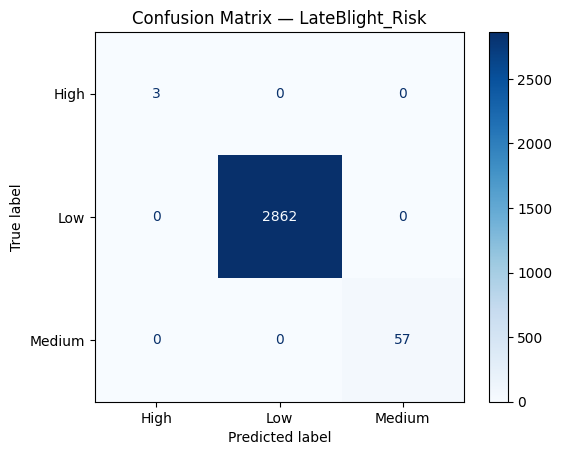

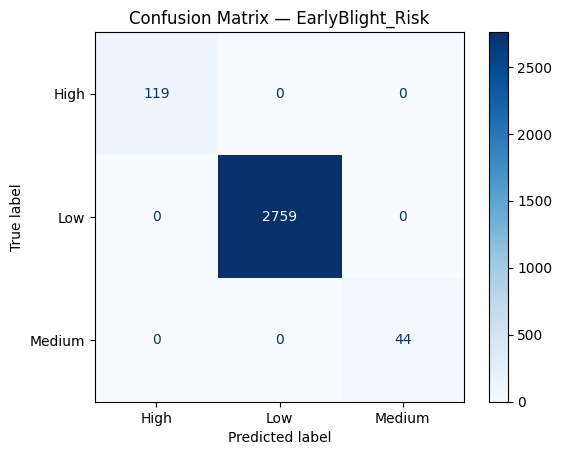

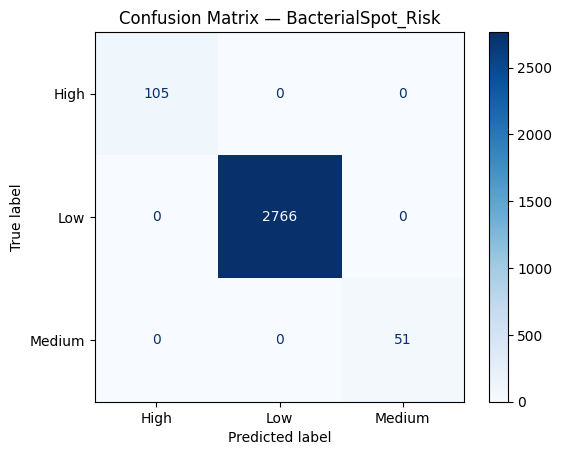

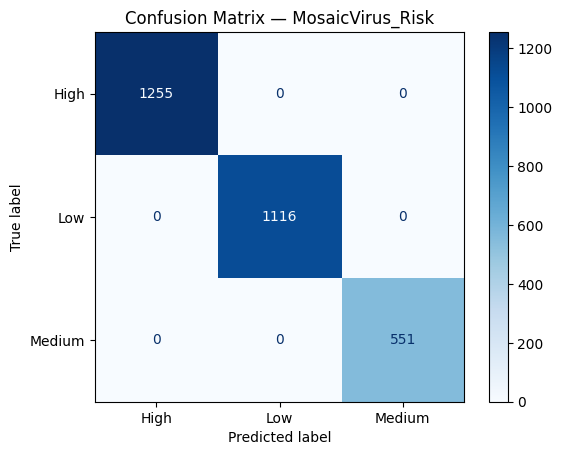

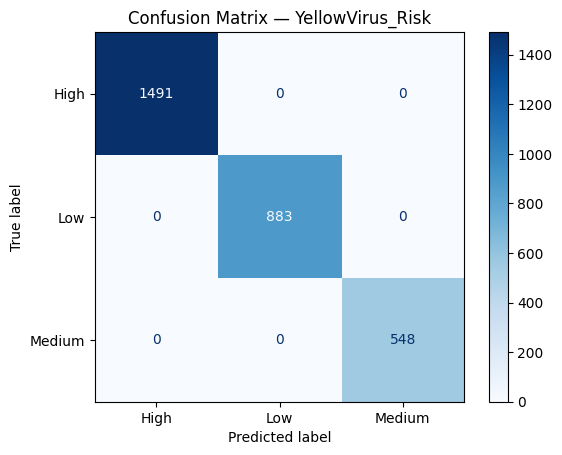

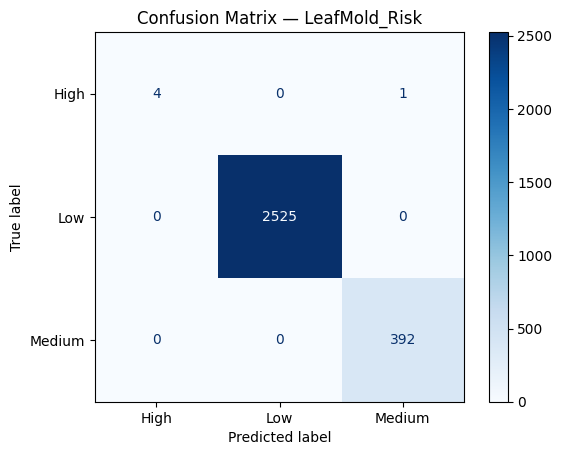

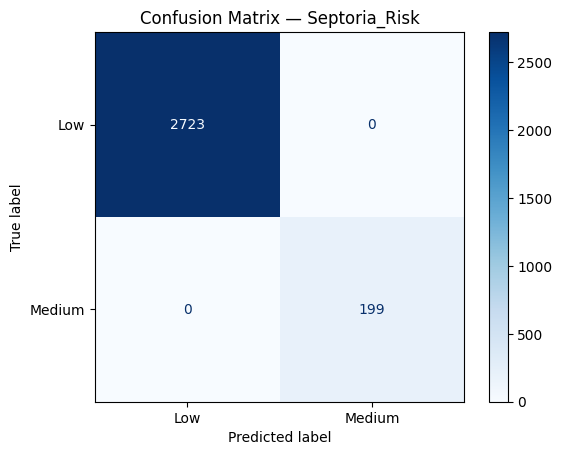

In [ ]:
y_pred = multi_rf.predict(X_test_scaled)

for i, col in enumerate(target_cols):
    y_true = y_test[col]
    y_pred_col = y_pred[:, i]

    labels_present = np.unique(np.concatenate((y_true, y_pred_col)))
    disp = ConfusionMatrixDisplay(
        confusion_matrix(y_true, y_pred_col, labels=labels_present),
        display_labels=[encoders[col].inverse_transform([lbl])[0] for lbl in labels_present]
    )

    disp.plot(cmap='Blues')
    plt.title(f"Confusion Matrix — {col}")
    plt.show()


In [ ]:
metrics_summary = []

for i, col in enumerate(target_cols):
    y_true = y_test[col]
    y_pred_col = y_pred[:, i]

    acc = accuracy_score(y_true, y_pred_col)
    prec = precision_score(y_true, y_pred_col, average='weighted', zero_division=0)
    rec = recall_score(y_true, y_pred_col, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred_col, average='weighted', zero_division=0)

    metrics_summary.append({
        'Disease': col,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1 Score': f1
    })

metrics_df = pd.DataFrame(metrics_summary)
metrics_df


,Disease,Accuracy,Precision,Recall,F1 Score
0,LateBlight_Risk,1.000000,1.000000,1.000000,1.000000
1,EarlyBlight_Risk,1.000000,1.000000,1.000000,1.000000
2,BacterialSpot_Risk,1.000000,1.000000,1.000000,1.000000
3,MosaicVirus_Risk,1.000000,1.000000,1.000000,1.000000
4,YellowVirus_Risk,1.000000,1.000000,1.000000,1.000000
5,LeafMold_Risk,0.999658,0.999659,0.999658,0.999639
6,Septoria_Risk,1.000000,1.000000,1.000000,1.000000


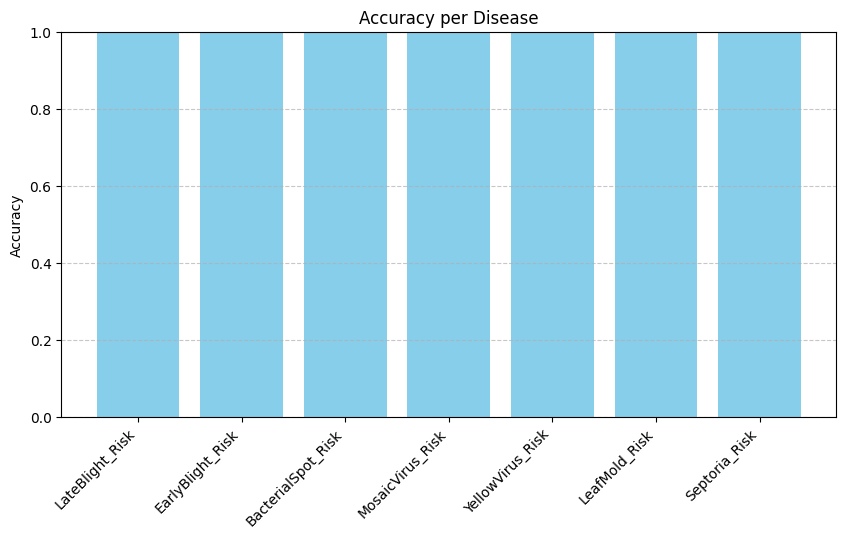

In [ ]:
plt.figure(figsize=(10, 5))
plt.bar(metrics_df['Disease'], metrics_df['Accuracy'], color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1)
plt.title("Accuracy per Disease")
plt.ylabel("Accuracy")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [ ]:
avg_metrics = metrics_df[['Accuracy', 'Precision', 'Recall', 'F1 Score']].mean()
print("🔹 Average Model Performance Across All Diseases:")
print(avg_metrics)


🔹 Average Model Performance Across All Diseases:
Accuracy     0.999951
Precision    0.999951
Recall       0.999951
F1 Score     0.999948
dtype: float64



🌟 Top Important Features (for first disease model):
rhmean             0.331941
rhmin              0.216041
tmax               0.135084
solar              0.105644
tmean              0.083690
rhmax              0.050976
tmin               0.045269
rain               0.019429
LeafWetness_est    0.009325
wind               0.002601
dtype: float64


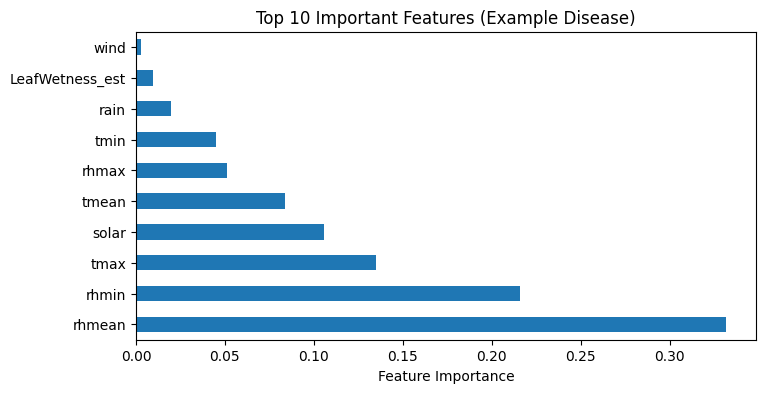

In [ ]:
first_rf = multi_rf.estimators_[0].best_estimator_

importances = pd.Series(first_rf.feature_importances_, index=X.columns).sort_values(ascending=False)

print("\n🌟 Top Important Features (for first disease model):")
print(importances.head(10))

plt.figure(figsize=(8,4))
importances.head(10).plot(kind='barh')
plt.title("Top 10 Important Features (Example Disease)")
plt.xlabel("Feature Importance")
plt.show()


In [ ]:
model_path = '/content/drive/MyDrive/TomatoDisease_MultiOutput_RF.pkl'
enc_path = '/content/drive/MyDrive/TomatoDisease_LabelEncoders.pkl'
scaler_path = '/content/drive/MyDrive/TomatoDisease_Scaler.pkl'

joblib.dump(multi_rf, model_path)
joblib.dump(encoders, enc_path)
joblib.dump(scaler, scaler_path)

print("💾 Model, encoders, and scaler saved successfully to Drive!")


💾 Model, encoders, and scaler saved successfully to Drive!


In [ ]:
# Load saved objects
model = joblib.load('/content/drive/MyDrive/TomatoDisease_MultiOutput_RF.pkl')
encoders = joblib.load('/content/drive/MyDrive/TomatoDisease_LabelEncoders.pkl')
scaler = joblib.load('/content/drive/MyDrive/TomatoDisease_Scaler.pkl')

# Example new input (replace with live app data)
new_data = pd.DataFrame([{
    'tmax': 32,
    'tmin': 24,
    'rain': 3.2,
    'rhmax': 85,
    'rhmin': 70,
    'solar': 6.5,
    'wind': 2.3,
    'tmean': 28,
    'rhmean': 77,
    'LeafWetness_est': 4.8
}])

# Scale and predict
new_data_scaled = scaler.transform(new_data)
pred_encoded = model.predict(new_data_scaled)

# Decode predictions
decoded_preds = {
    disease: encoders[disease].inverse_transform(pred_encoded[:, i])[0]
    for i, disease in enumerate(encoders.keys())
}

print("\n🌿 Predicted Disease Risks:")
for disease, risk in decoded_preds.items():
    print(f"{disease:25} → {risk}")



🌿 Predicted Disease Risks:
LateBlight_Risk           → Low
EarlyBlight_Risk          → Low
BacterialSpot_Risk        → Low
MosaicVirus_Risk          → High
YellowVirus_Risk          → High
LeafMold_Risk             → Medium
Septoria_Risk             → Medium


In [ ]:
# =======================================================
# 🧠 Convert Random Forest model (.pkl) → (.h5) safely
# =======================================================

import joblib
import h5py
import numpy as np
import pickle  # <-- use pickle for byte serialization

# Path to your existing saved model (.pkl)
pkl_path = '/content/drive/MyDrive/TomatoDisease_MultiOutput_RF.pkl'

# Load your Random Forest model
model = joblib.load(pkl_path)

# Save it into an HDF5 (.h5) file
h5_path = '/content/drive/MyDrive/TomatoDisease_MultiOutput_RF.h5'

with h5py.File(h5_path, 'w') as hf:
    model_bytes = pickle.dumps(model)           # ✅ use pickle to serialize
    hf.create_dataset('random_forest_model', data=np.void(model_bytes))

print("✅ Model successfully converted and saved as H5 file!")
print("📂 Location:", h5_path)


✅ Model successfully converted and saved as H5 file!
📂 Location: /content/drive/MyDrive/TomatoDisease_MultiOutput_RF.h5


In [ ]:
import joblib, h5py, numpy as np, pickle

# Paths to your existing objects
model = joblib.load('/content/drive/MyDrive/TomatoDisease_MultiOutput_RF.pkl')
encoders = joblib.load('/content/drive/MyDrive/TomatoDisease_LabelEncoders.pkl')
scaler = joblib.load('/content/drive/MyDrive/TomatoDisease_Scaler.pkl')

# Save them all into a single .h5 file
h5_path = '/content/drive/MyDrive/TomatoDisease_CompleteModel.h5'

with h5py.File(h5_path, 'w') as hf:
    hf.create_dataset('model', data=np.void(pickle.dumps(model)))
    hf.create_dataset('encoders', data=np.void(pickle.dumps(encoders)))
    hf.create_dataset('scaler', data=np.void(pickle.dumps(scaler)))

print("✅ All components saved together as:", h5_path)


✅ All components saved together as: /content/drive/MyDrive/TomatoDisease_CompleteModel.h5
